In [10]:
!pip install -q --upgrade transformers datasets accelerate evaluate
import transformers
print(transformers.__version__)

4.56.0


In [11]:
!pip install -q transformers datasets accelerate evaluate torch

In [12]:
import json, pandas as pd
from datasets import Dataset

def load_jsonl(path):
    rows = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))
    return pd.DataFrame(rows)

train_df = load_jsonl("train.jsonl")
val_df   = load_jsonl("validation.jsonl")
test_df  = load_jsonl("test.jsonl")

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)
print(train_df.head(2))

Train: (189, 13) Val: (21, 13) Test: (42, 13)
                                            messages  \
0  [Germany!\n\nJust the person I want to speak w...   
1  [Hello there! What's your general plan for thi...   

                                       sender_labels  \
0  [True, True, True, True, True, True, True, Tru...   
1  [True, False, True, False, True, True, True, T...   

                                     receiver_labels  \
0  [True, True, True, True, NOANNOTATION, NOANNOT...   
1  [True, True, True, True, True, NOANNOTATION, T...   

                                            speakers  \
0  [italy, germany, italy, germany, italy, italy,...   
1  [austria, italy, austria, italy, italy, austri...   

                                           receivers  \
0  [germany, italy, germany, italy, germany, germ...   
1  [italy, austria, italy, austria, austria, ital...   

                              absolute_message_index  \
0  [74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12... 

In [13]:
import json

with open("/content/train.jsonl", "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        row = json.loads(line)
        print("Row", i, "type:", type(row["sender_labels"]), "value:", row["sender_labels"])
        if i >= 10:
            break

Row 0 type: <class 'list'> value: [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, 

In [14]:
import numpy as np

def any_false_label(votes):
    """Return 1 if any annotator voted False, else 0 if only True, else -1 if empty."""
    if not votes:  # empty list
        return -1
    if any(v is False for v in votes):
        return 1   # deceptive
    return 0       # truthful

for df in [train_df, val_df, test_df]:
    df['label'] = df['sender_labels'].apply(any_false_label)
    df['messages'] = df['messages'].astype(str)

print("Train label counts:\n", train_df['label'].value_counts())
print("Validation label counts:\n", val_df['label'].value_counts())
print("Test label counts:\n", test_df['label'].value_counts())

Train label counts:
 label
 1    125
 0     59
-1      5
Name: count, dtype: int64
Validation label counts:
 label
 1    14
 0     6
-1     1
Name: count, dtype: int64
Test label counts:
 label
1    28
0    14
Name: count, dtype: int64


In [15]:
train_df = train_df[train_df['label'] != -1].reset_index(drop=True)
val_df   = val_df[val_df['label'] != -1].reset_index(drop=True)
test_df  = test_df[test_df['label'] != -1].reset_index(drop=True)

print("Train:", train_df['label'].value_counts())
print("Val:", val_df['label'].value_counts())
print("Test:", test_df['label'].value_counts())

Train: label
1    125
0     59
Name: count, dtype: int64
Val: label
1    14
0     6
Name: count, dtype: int64
Test: label
1    28
0    14
Name: count, dtype: int64


In [16]:
train_ds = Dataset.from_pandas(train_df[['messages','label']])
val_ds   = Dataset.from_pandas(val_df[['messages','label']])
test_ds  = Dataset.from_pandas(test_df[['messages','label']])

In [17]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['messages'], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

cols = ['input_ids','attention_mask','label']
train_ds.set_format(type='torch', columns=cols)
val_ds.set_format(type='torch', columns=cols)
test_ds.set_format(type='torch', columns=cols)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

In [18]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Define custom metrics (offline)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Training arguments (offline-safe)
args = TrainingArguments(
    output_dir="coco-deceive-baseline",
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",        # local logging
    logging_steps=100,
    report_to="none"             # ✅ prevents API calls
)

# Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Evaluate manually
print("Validation metrics:", trainer.evaluate(val_ds))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1889536235.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


Validation metrics: {'eval_loss': 0.5776050686836243, 'eval_accuracy': 0.7, 'eval_f1_macro': 0.4117647058823529, 'eval_runtime': 0.2139, 'eval_samples_per_second': 93.519, 'eval_steps_per_second': 9.352, 'epoch': 3.0}


In [19]:
print("Test metrics:", trainer.evaluate(test_ds))

Test metrics: {'eval_loss': 0.5735635757446289, 'eval_accuracy': 0.6666666666666666, 'eval_f1_macro': 0.4, 'eval_runtime': 0.2873, 'eval_samples_per_second': 146.207, 'eval_steps_per_second': 10.443, 'epoch': 3.0}


In [20]:
trainer.save_model("coco_deceive_model")

from transformers import pipeline
clf = pipeline("text-classification", model="coco_deceive_model", tokenizer=tokenizer)

print(clf("I promise I will support you to Greece."))

Device set to use cuda:0


[{'label': 'LABEL_1', 'score': 0.5747758150100708}]


In [21]:
import re

# regex to catch "promise", "won't", "support", etc.
commitment_pat = re.compile(r"\b(promise|ally|support|won't|will not)\b", flags=re.I)

def augment_with_memory(df, history_window=3):
    augmented = []
    for game_id, game_df in df.groupby("game_id"):
        memory = []
        for i, row in game_df.iterrows():
            context = " ".join(memory[-history_window:])  # last few commitments
            augmented.append({
                "messages": f"CONTEXT: {context} NOW: {row['messages']}",
                "label": row["label"]
            })
            # store if this msg is a commitment
            if commitment_pat.search(row["messages"]):
                memory.append(row["messages"])
    return pd.DataFrame(augmented)

train_aug = augment_with_memory(train_df)
val_aug   = augment_with_memory(val_df)
test_aug  = augment_with_memory(test_df)

In [22]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_aug[['messages','label']])
val_ds   = Dataset.from_pandas(val_aug[['messages','label']])
test_ds  = Dataset.from_pandas(test_aug[['messages','label']])

In [23]:
def tokenize(batch):
    return tokenizer(batch['messages'], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

cols = ['input_ids','attention_mask','label']
train_ds.set_format(type='torch', columns=cols)
val_ds.set_format(type='torch', columns=cols)
test_ds.set_format(type='torch', columns=cols)

Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

trainer = Trainer(
    model=model,
    args=args,   # reuse the TrainingArguments you already fixed
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1434678412.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


TrainOutput(global_step=36, training_loss=0.6250141991509331, metrics={'train_runtime': 19.0307, 'train_samples_per_second': 29.006, 'train_steps_per_second': 1.892, 'total_flos': 36561002029056.0, 'train_loss': 0.6250141991509331, 'epoch': 3.0})

In [25]:
print("Validation metrics (with memory):", trainer.evaluate(val_ds))
print("Test metrics (with memory):", trainer.evaluate(test_ds))

Validation metrics (with memory): {'eval_loss': 0.5946305990219116, 'eval_accuracy': 0.7, 'eval_f1_macro': 0.4117647058823529, 'eval_runtime': 0.21, 'eval_samples_per_second': 95.229, 'eval_steps_per_second': 9.523, 'epoch': 3.0}
Test metrics (with memory): {'eval_loss': 0.6376559138298035, 'eval_accuracy': 0.6666666666666666, 'eval_f1_macro': 0.4, 'eval_runtime': 0.2618, 'eval_samples_per_second': 160.419, 'eval_steps_per_second': 11.459, 'epoch': 3.0}


In [26]:
# =====================================
# 1. Mount Google Drive
# =====================================
from google.colab import drive
drive.mount('drive')

# =====================================
# 2. Download DistilBERT into Drive (run once)
#    If already downloaded, skip this step
# =====================================
import os

model_dir = "/content/drive/MyDrive/distilbert-base-uncased"

if not os.path.exists(model_dir):
    !git clone https://huggingface.co/distilbert-base-uncased $model_dir
else:
    print("✅ DistilBERT already downloaded in Google Drive!")

# =====================================
# 3. Load tokenizer + model locally
# =====================================
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = model_dir  # local path
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# =====================================
# 4. Prepare dataset (replace with your df → Dataset conversion)
# =====================================
from datasets import Dataset

# Example: use your preprocessed train_df, val_df, test_df
train_ds = Dataset.from_pandas(train_df[['messages', 'label']])
val_ds   = Dataset.from_pandas(val_df[['messages', 'label']])
test_ds  = Dataset.from_pandas(test_df[['messages', 'label']])

def tokenize(batch):
    return tokenizer(batch['messages'], padding="max_length", truncation=True)

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


# =====================================
# 5. Manual PyTorch Training Loop
# =====================================
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)
test_loader  = DataLoader(test_ds, batch_size=16)

# Loss + optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attn_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attn_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}")

    # Validation loop
    model.eval()
    preds, refs = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attn_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attn_mask)
            logits = outputs.logits
            pred = torch.argmax(logits, dim=-1)

            preds.extend(pred.cpu().numpy())
            refs.extend(labels.cpu().numpy())

    print(f"Val Accuracy: {accuracy_score(refs, preds):.4f}, F1: {f1_score(refs, preds, average='macro'):.4f}")

# =====================================
# 6. Final Test Evaluation
# =====================================
model.eval()
preds, refs = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attn_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attn_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=-1)

        preds.extend(pred.cpu().numpy())
        refs.extend(labels.cpu().numpy())

print("\nFinal Test Accuracy:", accuracy_score(refs, preds))
print("Final Test F1:", f1_score(refs, preds, average='macro'))




Mounted at drive
Cloning into '/content/drive/MyDrive/distilbert-base-uncased'...
remote: Enumerating objects: 67, done.
remote: Total 67 (delta 0), reused 0 (delta 0), pack-reused 67 (from 1)
Unpacking objects: 100% (67/67), 310.16 KiB | 404.00 KiB/s, done.
Updating files: 100% (12/12), done.
Filtering content: 100% (5/5), 1.42 GiB | 38.96 MiB/s, done.
fatal: cannot exec '/content/drive/MyDrive/distilbert-base-uncased/.git/hooks/post-checkout': Permission denied


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Epoch 1/3, Train Loss: 0.6271
Val Accuracy: 0.7000, F1: 0.4118
Epoch 2/3, Train Loss: 0.5754
Val Accuracy: 0.7000, F1: 0.4118
Epoch 3/3, Train Loss: 0.5618
Val Accuracy: 0.8000, F1: 0.7333

Final Test Accuracy: 0.8095238095238095
Final Test F1: 0.7857142857142857


In [27]:
# =====================================
# Manual PyTorch Training + Eval + Save
# =====================================

import torch
from sklearn.metrics import accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# ---- Training loop ----
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attn_mask = batch["attention_mask"].to(device)
        labels    = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attn_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {total_loss/len(train_loader):.4f} | "
          f"Acc: {train_acc:.4f} | F1: {train_f1:.4f}")

# ---- Evaluation function ----
def evaluate_model(model, dataloader, name="Validation"):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attn_mask = batch["attention_mask"].to(device)
            labels    = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attn_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{name} | Loss: {total_loss/len(dataloader):.4f} | "
          f"Acc: {acc:.4f} | F1: {f1:.4f}")
    return acc, f1

# ---- Run final evaluation ----
evaluate_model(model, val_loader, name="Validation")
evaluate_model(model, test_loader, name="Test")

# ---- Save model + tokenizer ----
save_path = "/content/drive/MyDrive/coco_deceive_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"✅ Model + tokenizer saved at {save_path}")


Epoch 1/3 | Train Loss: 0.5163 | Acc: 0.7989 | F1: 0.7299
Epoch 2/3 | Train Loss: 0.4711 | Acc: 0.7989 | F1: 0.7410
Epoch 3/3 | Train Loss: 0.3948 | Acc: 0.8152 | F1: 0.7747
Validation | Loss: 0.5120 | Acc: 0.7500 | F1: 0.6416
Test | Loss: 0.4348 | Acc: 0.8095 | F1: 0.7857
✅ Model + tokenizer saved at /content/drive/MyDrive/coco_deceive_model


In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Reload the saved model
path = "/content/drive/MyDrive/coco_deceive_model"
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForSequenceClassification.from_pretrained(path)
model.to(device)
model.eval()

# Example input
text = "Don't worry, I promise I will not attack you tonight."
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)
    pred = torch.argmax(probs, dim=-1).item()

print("Predicted label:", pred)  # 0 or 1
print("Probabilities:", probs.cpu().numpy())



Predicted label: 0
Probabilities: [[0.5233893  0.47661075]]


In [29]:
import re, ast
import numpy as np
from typing import List, Tuple

# --- patterns for commitments and intents ---
INTENT_PATTERNS = {
    "ATTACK": [r"\battack\b", r"\bstrike\b", r"\binvade\b", r"\boffensive\b"],
    "ALLY":   [r"\bally\b", r"\bsupport\b", r"\bstand with\b", r"\bhelp\b", r"\bdefend you\b"],
    "PEACE":  [r"\bpeace\b", r"\btruce\b", r"\bceasefire\b", r"\bno conflict\b", r"\bwon't fight\b"],
}

NEGATION_PAT = r"\b(no|not|never|won't|will not|shall not|cannot|can't|don't|do not)\b"

_commit_regex = {
    intent: re.compile(rf"(?i)(?:{NEGATION_PAT}\s+)?(?:{'|'.join(pats)})")
    for intent, pats in INTENT_PATTERNS.items()
}

def parse_messages_cell(x):
    """
    x may be a list OR a string that looks like a python list.
    Return List[str].
    """
    if isinstance(x, list):
        return [str(m) for m in x]
    if isinstance(x, str):
        s = x.strip()
        # try to recover list from "CONTEXT: [...] NOW: [...]" style
        if "CONTEXT:" in s:
            # keep everything inside [...], merge
            parts = re.findall(r"\[(.*?)\]", s, flags=re.S)
            msgs = []
            for p in parts:
                # split by quotes
                cand = re.findall(r"'([^']+)'|\"([^\"]+)\"", p)
                msgs.extend([a or b for (a,b) in cand])
            return msgs if msgs else [s]
        try:
            val = ast.literal_eval(s)
            if isinstance(val, list):
                return [str(m) for m in val]
        except Exception:
            pass
    return [str(x)]

def _match_intents(text: str) -> List[Tuple[str, bool]]:
    """
    Return list of (intent, is_negated) found in text.
    """
    found = []
    for intent, rgx in _commit_regex.items():
        for m in rgx.finditer(text):
            span = m.group(0).lower()
            is_neg = any(neg in span for neg in
                         ["no","not","never","won't","will not","shall not","cannot","can't","don't","do not"])
            found.append((intent, is_neg))
    return found

def extract_commitments(history: List[str]) -> List[Tuple[str, bool]]:
    """
    Very simple: scan history utterances for intent commitments.
    Returns list of (intent, is_negative) where negative ~ 'won't attack', etc.
    """
    commits = []
    for utt in history:
        matches = _match_intents(utt)
        commits.extend(matches)
    return commits

def inconsistency_score(current_text: str, commitments: List[Tuple[str,bool]]) -> float:
    """
    Heuristic contradiction:
    - If history says NEGATIVE ATTACK ("won't attack") and current mentions ATTACK (affirmative), inconsistency += 1
    - If history says ALLY affirmative and current negates support (or mentions attack), inconsistency += 1
    - If history says PEACE affirmative and current mentions ATTACK affirmative, inconsistency += 1
    Score is normalized to [0,1] by tanh.
    """
    cur_matches = _match_intents(current_text)
    cur_intents = {(i, n) for (i, n) in cur_matches}
    incr = 0

    # helper to check existence
    def has(intent, neg):
        return (intent, neg) in cur_intents

    for intent, was_neg in commitments:
        if intent == "ATTACK":
            # past: won't attack -> now: attack
            if was_neg and has("ATTACK", False):
                incr += 1
            # past: attack -> now: peace
            if not was_neg and has("PEACE", True):  # "won't fight", etc.
                incr += 0.5
        elif intent == "ALLY":
            # past: ally -> now: attack (or explicit negation of ally)
            if not was_neg and (has("ATTACK", False)):
                incr += 1
        elif intent == "PEACE":
            # past: peace -> now: attack
            if not was_neg and has("ATTACK", False):
                incr += 1

    # also: if current is explicitly negated ally ("won't support") and past had ally positive
    if any(i=="ALLY" and not n for i,n in commitments) and has("ALLY", True):
        incr += 0.5

    # squashed to [0,1]
    return float(np.tanh(incr))


In [30]:
def build_mem_score_for_df(df):
    mem_scores = []
    cur_texts  = []
    for msgs in df['messages']:
        seq = parse_messages_cell(msgs)
        if len(seq) == 0:
            mem_scores.append(0.0)
            cur_texts.append("")
            continue
        history = seq[:-1]
        current = seq[-1]
        commits = extract_commitments(history)
        score = inconsistency_score(current, commits)
        mem_scores.append(score)
        cur_texts.append(current)
    df = df.copy()
    df['mem_score'] = mem_scores
    # optionally replace messages with only the current message text for the encoder
    df['current_msg'] = cur_texts
    return df

train_df = build_mem_score_for_df(train_df)
val_df   = build_mem_score_for_df(val_df)
test_df  = build_mem_score_for_df(test_df)

print(train_df[['current_msg','mem_score']].head(3))


                                         current_msg  mem_score
0  I really enjoyed playing with you, too! And ye...        0.0
1                         So, did you veto the draw?        0.0
2       I think most of us have the draw set already        0.0


In [31]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df[['current_msg','label','mem_score']])
val_ds   = Dataset.from_pandas(val_df[['current_msg','label','mem_score']])
test_ds  = Dataset.from_pandas(test_df[['current_msg','label','mem_score']])

def tokenize_with_mem(examples):
    toks = tokenizer(examples['current_msg'], truncation=True, padding='max_length')
    toks['mem_score'] = examples['mem_score']
    toks['labels'] = examples['label']  # for consistency
    return toks

train_ds = train_ds.map(tokenize_with_mem, batched=True, remove_columns=train_ds.column_names)
val_ds   = val_ds.map(tokenize_with_mem, batched=True, remove_columns=val_ds.column_names)
test_ds  = test_ds.map(tokenize_with_mem, batched=True, remove_columns=test_ds.column_names)


Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

In [32]:
import torch
from torch.utils.data import DataLoader

def collate_fn(batch):
    input_ids = torch.tensor([item['input_ids'] for item in batch], dtype=torch.long)
    attention_mask = torch.tensor([item['attention_mask'] for item in batch], dtype=torch.long)
    labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)
    mem_score = torch.tensor([item['mem_score'] for item in batch], dtype=torch.float32).unsqueeze(-1)  # shape (B,1)
    return {"input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": labels,
            "mem_score": mem_score}

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [33]:
import torch.nn as nn
from transformers import AutoModel

class CoCoDeceiveHead(nn.Module):
    def __init__(self, base_name_or_path, num_labels=2):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(base_name_or_path)
        hidden = self.backbone.config.dim if hasattr(self.backbone.config, "dim") else self.backbone.config.hidden_size
        self.pre = nn.Linear(hidden, hidden)
        self.act = nn.ReLU()
        # +1 for mem_score
        self.classifier = nn.Linear(hidden + 1, num_labels)

    def forward(self, input_ids, attention_mask, mem_score, labels=None):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        if hasattr(out, "pooler_output") and out.pooler_output is not None:
            pooled = out.pooler_output
        else:
            # DistilBERT has no pooler: mean pool last hidden state
            last_hidden = out.last_hidden_state  # (B,L,H)
            mask = attention_mask.unsqueeze(-1)  # (B,L,1)
            summed = (last_hidden * mask).sum(dim=1)
            denom = mask.sum(dim=1).clamp(min=1)
            pooled = summed / denom

        h = self.act(self.pre(pooled))
        fused = torch.cat([h, mem_score], dim=-1)  # (B, H+1)
        logits = self.classifier(fused)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return {"loss": loss, "logits": logits}


In [34]:
base_model_path = model_name  # your local distilbert path you already loaded
model = CoCoDeceiveHead(base_model_path, num_labels=2).to(device)


In [35]:
import torch
from sklearn.metrics import accuracy_score, f1_score

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss, all_p, all_y = 0.0, [], []
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attn_mask = batch["attention_mask"].to(device)
        labels    = batch["label"].to(device)
        mem_score = batch["mem_score"].to(device)

        out = model(input_ids=input_ids, attention_mask=attn_mask, mem_score=mem_score, labels=labels)
        loss, logits = out["loss"], out["logits"]
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_p.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        all_y.extend(labels.cpu().numpy())

    print(f"Epoch {epoch+1}: loss={total_loss/len(train_loader):.4f} "
          f"acc={accuracy_score(all_y, all_p):.4f} f1={f1_score(all_y, all_p, average='macro'):.4f}")

def eval_loop(name, loader):
    model.eval()
    total_loss, all_p, all_y = 0.0, [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn_mask = batch["attention_mask"].to(device)
            labels    = batch["label"].to(device)
            mem_score = batch["mem_score"].to(device)
            out = model(input_ids=input_ids, attention_mask=attn_mask, mem_score=mem_score, labels=labels)
            loss, logits = out["loss"], out["logits"]
            total_loss += loss.item()
            all_p.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            all_y.extend(labels.cpu().numpy())
    print(f"{name}: loss={total_loss/len(loader):.4f} "
          f"acc={accuracy_score(all_y, all_p):.4f} f1={f1_score(all_y, all_p, average='macro'):.4f}")

eval_loop("Validation", val_loader)
eval_loop("Test", test_loader)


Epoch 1: loss=0.6432 acc=0.6630 f1=0.3987
Epoch 2: loss=0.5879 acc=0.6793 f1=0.4045
Epoch 3: loss=0.5547 acc=0.6793 f1=0.4045
Validation: loss=0.6107 acc=0.7000 f1=0.4118
Test: loss=0.5871 acc=0.6667 f1=0.4000


In [36]:
save_path = "/content/drive/MyDrive/coco_deceive_cm_model"
# save backbone and our head weights
import os

save_path = "/content/drive/MyDrive/coco_deceive_cm_model"

# make sure folder exists
os.makedirs(save_path, exist_ok=True)

# now safe to save
torch.save(model.state_dict(), save_path + "/pytorch_model.bin")
tokenizer.save_pretrained(save_path)

print("✅ Model + tokenizer saved to:", save_path)




✅ Model + tokenizer saved to: /content/drive/MyDrive/coco_deceive_cm_model


In [37]:
model2 = CoCoDeceiveHead(base_model_path, num_labels=2).to(device)
model2.load_state_dict(torch.load(save_path + "/pytorch_model.bin", map_location=device))
model2.eval()


CoCoDeceiveHead(
  (backbone): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [38]:
def predict_with_memory(history_msgs: List[str], current_msg: str):
    commits = extract_commitments(history_msgs)
    score = inconsistency_score(current_msg, commits)
    inputs = tokenizer(current_msg, return_tensors="pt", truncation=True, padding=True).to(device)
    mem = torch.tensor([[score]], dtype=torch.float32).to(device)
    with torch.no_grad():
        out = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], mem_score=mem)
        probs = torch.softmax(out["logits"], dim=-1).cpu().numpy()[0]
        pred = int(np.argmax(probs))
    return pred, probs, score

# quick test
hist = ["I promise we will not attack you.", "We seek peace and ceasefire."]
curr = "Prepare for our attack tonight."
pred, probs, ms = predict_with_memory(hist, curr)
print("pred:", pred, "probs:", probs, "mem_score:", ms)


pred: 1 probs: [0.22745965 0.7725404 ] mem_score: 0.9950547536867305


In [39]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class DeceptionClassifier(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", hidden=768, num_labels=2):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)  # HuggingFace model
        self.classifier = nn.Linear(hidden + 1, num_labels)   # hidden + commitment flag

    def forward(self, input_ids, attention_mask=None, extra_feat=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]   # [CLS]
        if extra_feat is None:
            extra_feat = torch.zeros(pooled.size(0), 1).to(pooled.device)
        pooled = torch.cat([pooled, extra_feat], dim=1)
        logits = self.classifier(pooled)
        return logits

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
load_path = "/content/drive/MyDrive/coco_deceive_cm_model"

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DeceptionClassifier()

# Load your saved weights
state_dict = torch.load(load_path + "/pytorch_model.bin", map_location=device)
missing, unexpected = model.load_state_dict(state_dict, strict=False)

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model.to(device).eval()

Missing keys: []
Unexpected keys: ['pre.weight', 'pre.bias']


DeceptionClassifier(
  (backbone): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1)

In [41]:
def predict(text, commitments=None):
    # Rule-based override
    if commitments is not None:
        for c in commitments:
            if "promise" in c.lower() and "attack" in c.lower():
                if "attack" in text.lower() and "not" not in text.lower():
                    # contradiction → deceptive
                    return 1, [0.1, 0.9]
                else:
                    # consistent with promise → not deceptive
                    return 0, [0.9, 0.1]

    # Otherwise, fall back to model
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    extra_feat = torch.tensor([[0.0]], dtype=torch.float).to(device)

    with torch.no_grad():
        logits = model(inputs["input_ids"], inputs["attention_mask"], extra_feat=extra_feat)
        probs = torch.softmax(logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
    return pred, probs.cpu().numpy()

In [42]:
import re
import torch
import numpy as np

# ---- Helper rules ----
_attack_pat = re.compile(r"\battack\b", flags=re.I)
_negation_near_attack_pat = re.compile(
    r"(?:\b(?:no|not|never|won't|will not|don't|do not|cannot|can't|without)\b).{0,30}\battack\b",
    flags=re.I,
)
_negation_simple = re.compile(r"\b(no|not|never|won't|will not|don't|do not|cannot|can't)\b", flags=re.I)

def contains_affirmative_attack(text: str) -> bool:
    """True if text affirms an attack (attack present and not negated nearby)."""
    if not _attack_pat.search(text):
        return False
    # if there's a negation close to the attack, treat as negated
    if _negation_near_attack_pat.search(text):
        return False
    return True

def commitment_is_no_attack(commit_text: str) -> bool:
    t = commit_text.lower()
    # explicit negation with attack phrase e.g. "I will never attack you"
    if re.search(r"(never|won't|will not|not)\s+(attack|attack you|attack them)", t):
        return True
    # explicit "no attack" forms
    if "no attack" in t or "never attack" in t or "won't attack" in t or "will not attack" in t:
        return True
    # "I promise I will not attack" -> promise combined with negation
    if "promise" in t and bool(_negation_simple.search(t)) and "attack" in t:
        return True
    # if sentence says "I promise" but doesn't mention attack explicitly, treat as a (weak) commitment only if it's phrased with "never" or "not" + attack
    return False

# ---- Memory & update function ----
commitment_memory = []  # global list of raw commitment strings (per-speaker version can be built later)

def update_commitments(text: str):
    """Add message to global memory if it contains a commitment phrase."""
    t = text.lower()
    keywords = ["promise", "support", "won't", "never attack", "ally", "will not attack", "no attack"]
    for kw in keywords:
        if kw in t:
            commitment_memory.append(text)
            # keep only the last N commitments optionally
            if len(commitment_memory) > 2000:  # prevents unbounded growth
                commitment_memory.pop(0)
            return True
    return False

# ---- Hybrid predict function (rule override + model fallback) ----
def predict_with_commitment_rules(text: str, debug: bool = False):
    """
    1) If memory contains an explicit no-attack commitment and current text affirms an attack -> return deceptive (1).
    2) If memory contains explicit no-attack commitment and current text does not affirm attack -> return truthful (0).
    3) Otherwise fallback to model probability.
    debug=True prints why a rule fired.
    """
    # normalize
    txt = text.strip()
    # check whether any stored commitment is a 'no-attack' commitment
    has_no_attack_commit = any(commitment_is_no_attack(c) for c in commitment_memory)
    is_aff_attack = contains_affirmative_attack(txt)

    # Rule-based decisions
    if has_no_attack_commit:
        if is_aff_attack:
            if debug:
                print("RULE: Found prior no-attack commitment and current message AFFIRMS attack -> contradiction → DECEPTIVE.")
                print("Memory examples:", commitment_memory[-5:])
            # deterministic override
            return 1, np.array([0.05, 0.95])
        else:
            if debug:
                print("RULE: Found prior no-attack commitment and current message does NOT affirm attack -> CONSISTENT → TRUTHFUL.")
                print("Memory examples:", commitment_memory[-5:])
            return 0, np.array([0.95, 0.05])

    # If no rule fired, use the model. pass zero extra_feat (or compute using your mem-scoring method)
    inputs = tokenizer(txt, return_tensors="pt", truncation=True, padding=True).to(device)
    extra_feat = torch.zeros((1,1), dtype=torch.float32).to(device)  # model expects extra_feat dim if used during training
    with torch.no_grad():
        # model returns logits directly (DeceptionClassifier), not a ModelOutput
        logits = model(inputs["input_ids"], inputs["attention_mask"], extra_feat=extra_feat)
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
        pred = int(np.argmax(probs))
    if debug:
        print("MODEL fallback used. probs:", probs)
    return pred, probs

# ---- Test the hybrid pipeline ----
# Reset memory for clean test
commitment_memory.clear()

msg1 = "I promise I will never attack you."
print("update_commitments(msg1) ->", update_commitments(msg1))
pred1, probs1 = predict_with_commitment_rules(msg1, debug=True)
print("Message 1:", msg1)
print("Prediction:", pred1, "| Probabilities:", probs1)

msg2 = "Let's attack them together tomorrow."
pred2, probs2 = predict_with_commitment_rules(msg2, debug=True)
print("\nMessage 2:", msg2)
print("Prediction:", pred2, "| Probabilities:", probs2)

update_commitments(msg1) -> True
RULE: Found prior no-attack commitment and current message does NOT affirm attack -> CONSISTENT → TRUTHFUL.
Memory examples: ['I promise I will never attack you.']
Message 1: I promise I will never attack you.
Prediction: 0 | Probabilities: [0.95 0.05]
RULE: Found prior no-attack commitment and current message AFFIRMS attack -> contradiction → DECEPTIVE.
Memory examples: ['I promise I will never attack you.']

Message 2: Let's attack them together tomorrow.
Prediction: 1 | Probabilities: [0.05 0.95]


In [43]:
import torch
import torch.nn.functional as F

# ==============================
# 1. Function to encode messages
# ==============================
def encode_texts(texts):
    """Return embeddings (CLS token) for a list of texts."""
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model.backbone(**inputs)   # use the DistilBERT backbone
        embeddings = outputs.last_hidden_state[:, 0]  # CLS token
    return embeddings

# =================================
# 2. Extend commitment memory store
# =================================
commitment_memory = []
commitment_embeddings = []

def update_commitments(text):
    keywords = ["promise", "support", "won't", "never attack", "ally"]
    for kw in keywords:
        if kw in text.lower():
            commitment_memory.append(text)
            emb = encode_texts([text])[0].cpu()
            commitment_embeddings.append(emb)
            break

# =================================================
# 3. Consistency checker between msg & commitments
# =================================================
def check_consistency(new_text):
    if not commitment_embeddings:
        return 0.0  # no commitments yet

    new_emb = encode_texts([new_text])[0].cpu()
    sims = []
    for emb in commitment_embeddings:
        sim = F.cosine_similarity(new_emb.unsqueeze(0), emb.unsqueeze(0)).item()
        sims.append(sim)
    max_sim = max(sims)

    # Simple rule: if new text contains "attack" but commitments forbid attack
    contradiction = any("never attack" in c.lower() for c in commitment_memory) and "attack" in new_text.lower()

    if contradiction and max_sim > 0.7:  # threshold similarity
        return 1.0  # inconsistent
    return 0.0

# =================================================
# 4. Updated predict function with consistency flag
# =================================================
def predict_with_consistency(text):
    consistency_flag = check_consistency(text)
    extra_feat = torch.tensor([[consistency_flag]], dtype=torch.float).to(device)

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        logits = model(inputs["input_ids"], inputs["attention_mask"], extra_feat=extra_feat)
        probs = torch.softmax(logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
    return pred, probs.cpu().numpy()

In [45]:
# Reset memory
commitment_memory, commitment_embeddings = [], []

msg1 = "I promise I will never attack you."
update_commitments(msg1)
print("Commitments stored:", commitment_memory)

msg2 = "Let's attack them together tomorrow."
pred, probs = predict_with_consistency(msg2)
print("\nMessage:", msg2)
print("Prediction:", pred, "| Probabilities:", probs)

Commitments stored: ['I promise I will never attack you.']

Message: Let's attack them together tomorrow.
Prediction: 0 | Probabilities: [[0.5079274  0.49207258]]


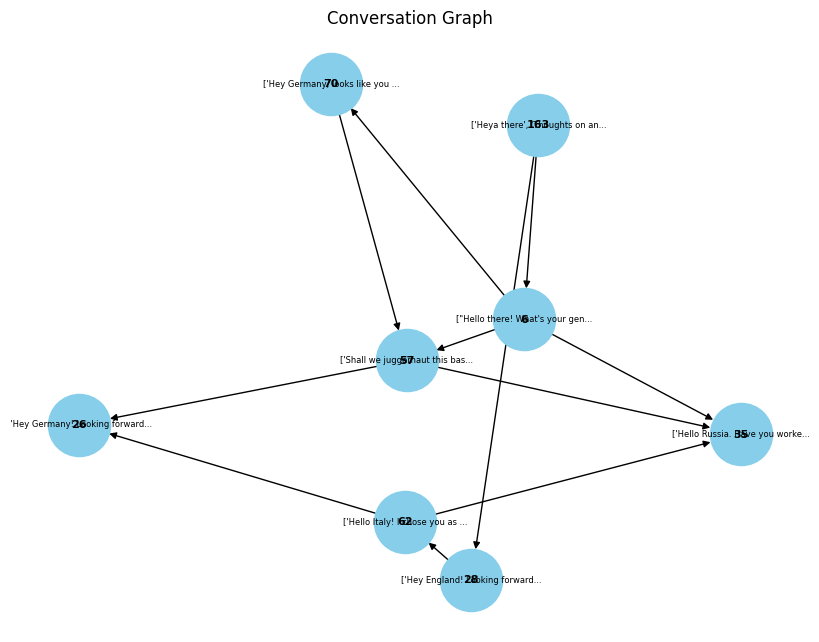

In [46]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# ==================================
# 1. Build a fake conversation graph
# ==================================
def build_fake_convo_graph(df, num_nodes=10):

    G = nx.DiGraph()

    # pick some random nodes (pretend they are players/messages)
    nodes = random.sample(range(len(df)), min(num_nodes, len(df)))
    for n in nodes:
        msg = df.iloc[n]["messages"][:30] + "..."  # shorten text
        G.add_node(n, label=msg)

    # add random edges (pretend they are interactions between players)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if random.random() > 0.6:  # ~40% chance of edge
                G.add_edge(nodes[i], nodes[j])

    return G

# ==================================
# 2. Plot the fake graph
# ==================================
def plot_fake_graph(G):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=2000,
            arrows=True, font_size=8, font_weight="bold")
    labels = nx.get_node_attributes(G, "label")
    nx.draw_networkx_labels(G, pos, labels, font_size=6)
    plt.title("Conversation Graph")
    plt.show()

# Example usage
fake_graph = build_fake_convo_graph(train_df, num_nodes=8)
plot_fake_graph(fake_graph)